# Defining and Training Neural Networks

What we will learn:
- How to initialize a NN
- Forward pass
- Backward pass
- Optimization of the network parameters

## Pytorch: <code>nn</code>

The <code>nn</code> package defines a set of Modules (i.e. neural networks layers).

Each module receive an input and produces an output.

The <code>nn</code> package also defines losses. 

In [ ]:
# Import libs
import torch
import torch.nn as nn

import math
from IPython import display

### Objective
Create a model that approximate the $sin(x)$ function.

In [ ]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

In [ ]:
# For this example, the netowrk will learn the Sin function using a Polynomial Approximation.
# The output y is a function of (x, x^2, x^3), so
# we can consider it as an output of a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3, 4])
xx = x.unsqueeze(-1).pow(p)
print(xx.size())

In [ ]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
model = torch.nn.Sequential(
    torch.nn.Linear(4, 1),
    torch.nn.Flatten(0, 1)
)

In [ ]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
# Construct the Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters
# which are members of the model.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### MSE Loss
$$\mathcal{L}_{MSE} = \frac{1}{n}\sum^n_{i=n}(y - \hat{y})^2$$

In [ ]:
for t in range(2000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(xx)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y) # (y_pred - y).pow(2).mean()
    
    # Print loss every 200 epochs
    if t % 200 == 199:
        print(t, loss.item())
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()
    
    # Alternative: zero the gradients of the model
    # model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward() 

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Alternative: Update the weights using gradient descent MANUALLY. Each parameter is a Tensor, so
    # we can access its gradients.
    """
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    """

In [ ]:
# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3 + {linear_layer.weight[:, 3].item()} x^4')

In [ ]:
# The network has effectively learned something?
print(xx[500]) # x[500] = -pi/2
print("%.6f %.6f" % (model(xx)[500].item(), torch.sin(x)[500]))

In [ ]:
# plot results
import matplotlib.pyplot as plt
from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

yy = model(xx)

plt.plot(x,y, label='Sin(x)')
plt.plot(x,yy.detach().numpy(), label='model(x)')
plt.legend()
plt.show()

## Custom models

In [ ]:
class SinModel(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate all the layer of the NN
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 1),
            nn.Flatten(0, 1)
        )
        """
        In alternative we could also define each layer individually
        """
        # self.l1 = nn.Linear(3, 1)
        # self.flt = nn.Flatten(0, 1)
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.model(x)
        # x = self.l1(x)
        # return self.flt(x)

In [ ]:
# Construct our model by instantiating the class defined above
model = SinModel()

print(model)

In [ ]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(xx)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 200 == 199:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# The network has effectively learned something?
print(xx[500]) # x[500] = -pi/2
print("%.6f %.6f" % (model(xx)[500].item(), torch.sin(x)[500]))

In [ ]:
yy = model(xx)

plt.plot(x,y, label='Sin(x)')
plt.plot(x,yy.detach().numpy(), label='model(x)')
plt.legend()
plt.show()

In [ ]:
# Ex1: write a model (using custom modules) where the output y is a function of (x, x^2, x^3, x^4)
# and it approximate the cosine function

In [1]:
# Import libs
import torch
import torch.nn as nn

import math
from IPython import display

In [2]:
class CosModel(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate all the layer of the NN
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 1),
            nn.Flatten(0, 1)
        )
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.model(x)

In [3]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-3*math.pi/2, math.pi/2, 20000)
y = torch.cos(x)
p = torch.tensor([1, 2, 3, 4])
xx = x.unsqueeze(-1).pow(p)
# Construct our model by instantiating the class defined above
model = CosModel()

In [4]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=4e-5)
for t in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(xx)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 200 == 199:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

199 0.366451621055603
399 0.3568522334098816
599 0.3503010869026184
799 0.3451883792877197
999 0.3407841920852661
1199 0.33675679564476013
1399 0.3329536020755768
1599 0.32930389046669006
1799 0.32577431201934814
1999 0.32234662771224976
2199 0.319011390209198
2399 0.31576278805732727
2599 0.31259652972221375
2799 0.3095090091228485
2999 0.30649706721305847
3199 0.30355796217918396
3399 0.30068886280059814
3599 0.2978871464729309
3799 0.2951505482196808
3999 0.2924766540527344
4199 0.2898631691932678
4399 0.2873079478740692
4599 0.2848087549209595
4799 0.2823638617992401
4999 0.2799711227416992
5199 0.2776288688182831
5399 0.27533531188964844
5599 0.27308860421180725
5799 0.27088719606399536
5999 0.2687295079231262
6199 0.26661404967308044
6399 0.26453936100006104
6599 0.2625040113925934
6799 0.2605067789554596
6999 0.25854623317718506
7199 0.25662118196487427
7399 0.25473055243492126
7599 0.25287291407585144
7799 0.2510474622249603
7999 0.24925296008586884
8199 0.24748849868774414
839

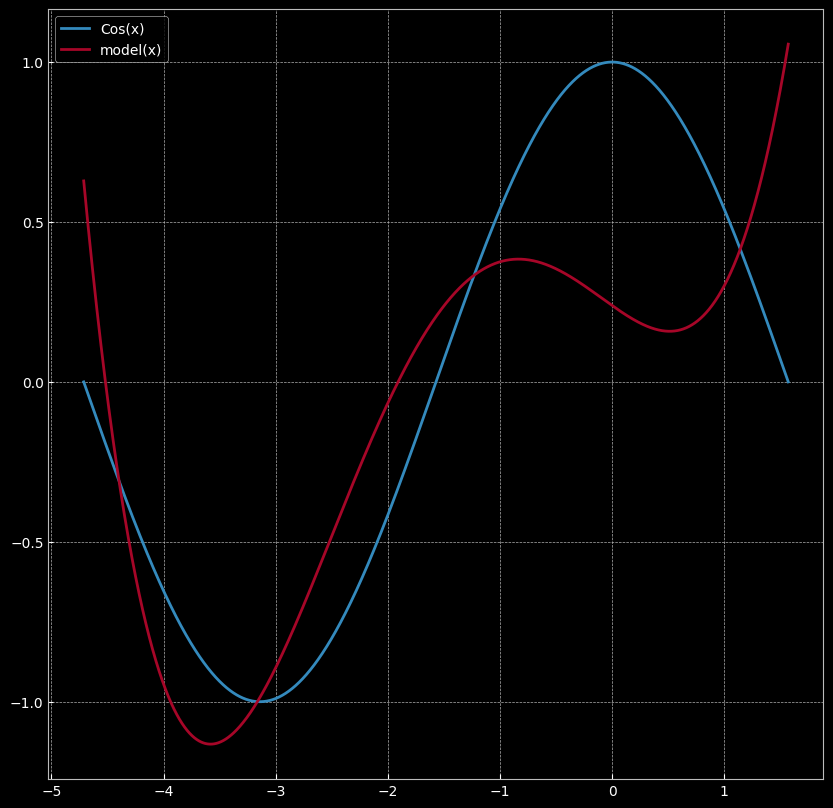

In [5]:
import matplotlib.pyplot as plt
from DeepLearningForEngineeringApplicationsCourse.res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()
yy = model(xx)

plt.plot(x,y, label='Cos(x)')
plt.plot(x,yy.detach().numpy(), label='model(x)')
plt.legend()
plt.show()

In [ ]:
# Ex2: write a model (using custom modules) where the output y is a function of (x, x^2, x^3)
# and it approximate the function -5 + 2*x + 3/4x^2 + 7*x^3

In [6]:
# Import libs
import torch
import torch.nn as nn

import math
from IPython import display

In [7]:
class PolyModel(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate all the layer of the NN
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 1),
            nn.Flatten(0, 1)
        )
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.model(x)

In [8]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-2, 2, 20000)
y = -5+2*x+3/4*x.pow(2)+7*x.pow(3)
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)
# Construct our model by instantiating the class defined above
model = PolyModel()

In [9]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=7e-6)
for t in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(xx)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 200 == 199:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

199 577.9452514648438
399 546.2855224609375
599 516.3922729492188
799 488.1668395996094
999 461.5159912109375
1199 436.3515930175781
1399 412.5904541015625
1599 390.1542663574219
1799 368.96881103515625
1999 348.9642028808594
2199 330.0743103027344
2399 312.2369384765625
2599 295.3931884765625
2799 279.487548828125
2999 264.4675598144531
3199 250.28367614746094
3399 236.88922119140625
3599 224.24008178710938
3799 212.2946014404297
3999 201.01345825195312
4199 190.35951232910156
4399 180.29782104492188
4599 170.79510498046875
4799 161.8202667236328
4999 153.34368896484375
5199 145.33767700195312
5399 137.77597045898438
5599 130.63369750976562
5799 123.88743591308594
5999 117.51512145996094
6199 111.49579620361328
6399 105.8099136352539
6599 100.43867492675781
6799 95.36465454101562
6999 90.5711441040039
7199 86.04249572753906
7399 81.76410675048828
7599 77.72191619873047
7799 73.90281677246094
7999 70.2942123413086
8199 66.88447570800781
8399 63.662574768066406
8599 60.61798095703125
87

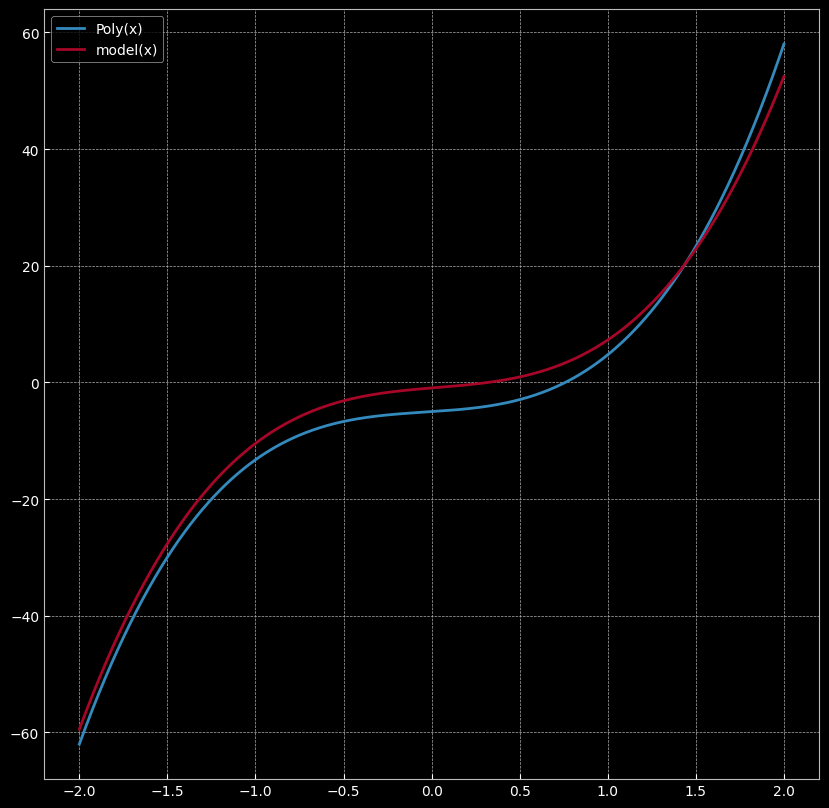

In [10]:
import matplotlib.pyplot as plt
from DeepLearningForEngineeringApplicationsCourse.res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()
yy = model(xx)

plt.plot(x,y, label='Poly(x)')
plt.plot(x,yy.detach().numpy(), label='model(x)')
plt.legend()
plt.show()